In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import warnings
warnings.filterwarnings('ignore')

c:\Users\prisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data/text.csv")

# visulize data

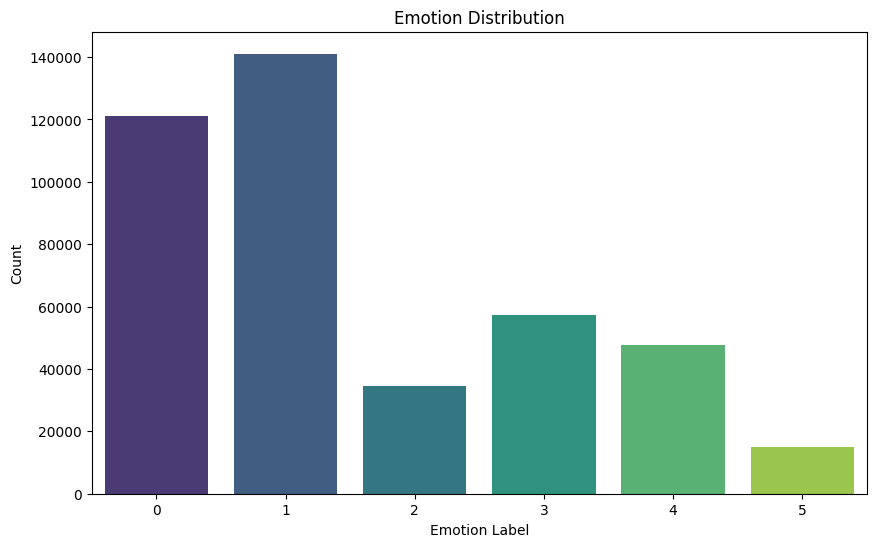

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Emotion Distribution')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.show()

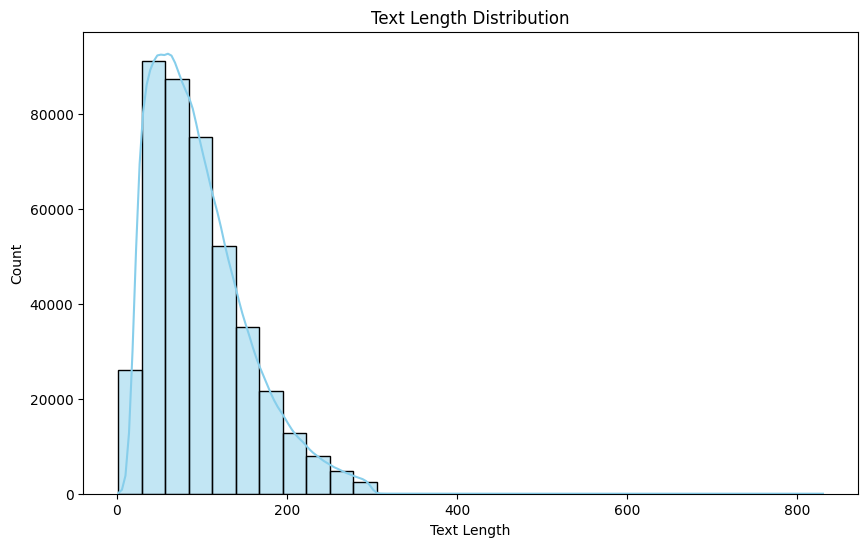

In [4]:
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df, x='text_length', bins=30, kde=True, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

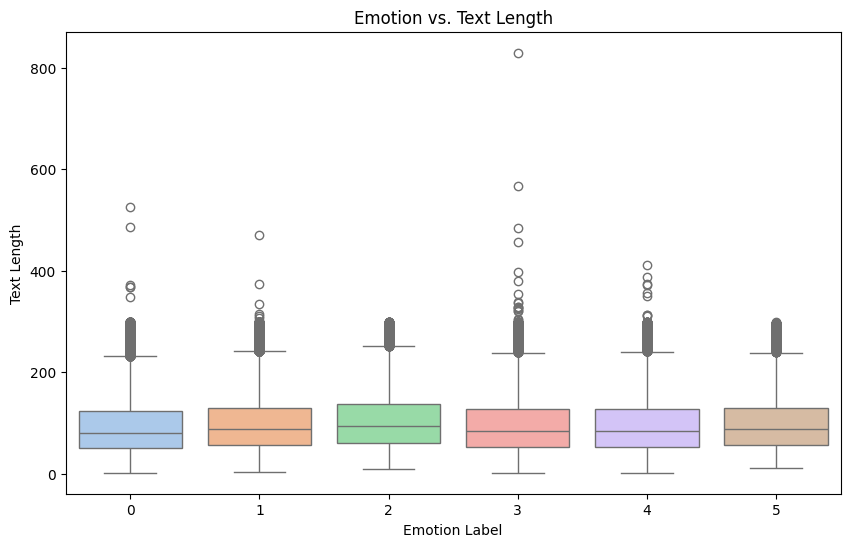

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=df, palette='pastel')
plt.title('Emotion vs. Text Length')
plt.xlabel('Emotion Label')
plt.ylabel('Text Length')
plt.show()

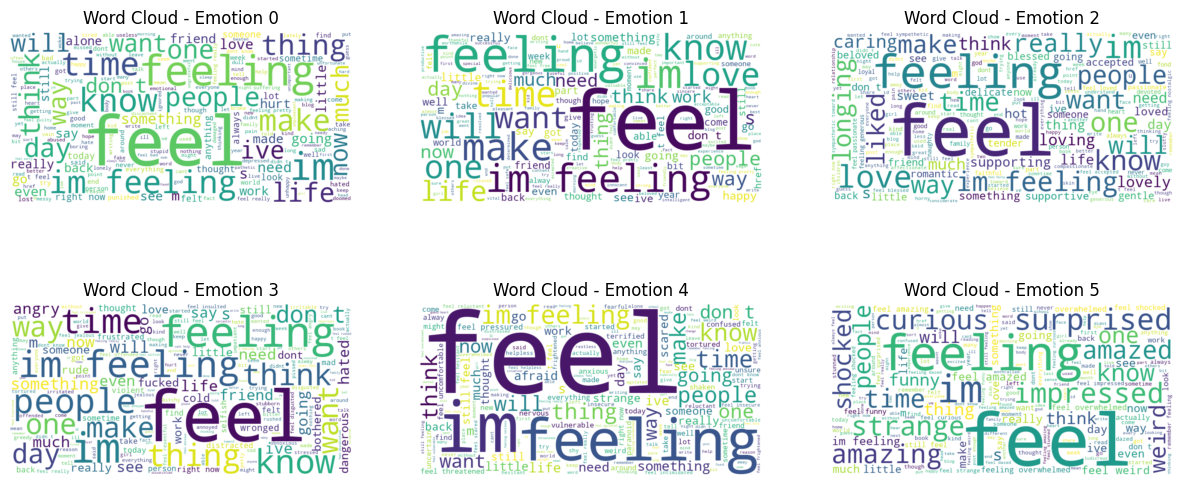

In [6]:
from wordcloud import WordCloud

emotions = df['label'].unique()
plt.figure(figsize=(15, 10))
for emotion in emotions:
    subset = df[df['label'] == emotion]
    text = ' '.join(subset['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.subplot(3, 3, emotion+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Emotion {emotion}')
    plt.axis('off')
plt.show()

# prepare

In [7]:
from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertForSequenceClassification

In [8]:
# Load the pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Tokenize the input text
def tokenize_data(texts, labels, max_len=128):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        truncation=True,
                                        padding='max_length',
                                        return_attention_mask=True,
                                        return_tensors='pt')
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0), torch.tensor(labels)

In [10]:
# Prepare data for training/testing
X = df['text'].tolist()
y = df['label'].tolist()

In [11]:
input_ids, attention_masks, labels = tokenize_data(X, y)
dataset = TensorDataset(input_ids, attention_masks, labels)

# model

In [12]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [13]:
# Set up device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [14]:
# Set hyperparameters
epochs = 2
batch_size = 16
learning_rate = 2e-5

kf = KFold(n_splits=5, shuffle=True, random_state=0)
accuracy_scores = []
classification_reports = []
confusion_matrices = []


In [15]:
# Loop over the KFold splits
for train_index, test_index in kf.split(dataset):
    train_data = torch.utils.data.Subset(dataset, train_index)
    test_data = torch.utils.data.Subset(dataset, test_index)
    
    train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    test_loader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)
    
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=0, 
                                                num_training_steps=total_steps)
    
    # Train the model
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            model.zero_grad()
            
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()
            
            optimizer.step()
            scheduler.step()
    
    # Evaluate the model
    model.eval()
    all_preds = []
    all_labels = []
    
    for batch in test_loader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())
    
    accuracy_scores.append(accuracy_score(all_labels, all_preds))
    classification_reports.append(classification_report(all_labels, all_preds, output_dict=True))
    confusion_matrices.append(confusion_matrix(all_labels, all_preds))

KeyboardInterrupt: 

In [ ]:
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
avg_classification_report = pd.DataFrame(classification_reports).mean(axis=0)
avg_confusion_matrix = sum(confusion_matrices) // len(confusion_matrices)

print("\nModel Evaluation:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print("\nClassification Report (Averaged):")
print(avg_classification_report)
print("\nConfusion Matrix (Averaged):")
print(avg_confusion_matrix)

In [ ]:
# print("\nModel Evaluation:")
# print("Average Accuracy:", sum(accuracy_scores) / len(accuracy_scores))
# print("\nClassification Reports:")
# for i, report in enumerate(classification_reports):
#     print(f"\nFold {i+1}:\n", pd.DataFrame(report).transpose())
# print("\nConfusion Matrices:")
# for i, matrix in enumerate(confusion_matrices):
#     print(f"\nFold {i+1}:\n", matrix)